# Import necessary packages

In [44]:
import numpy as np
import pandas as pd
import math
from scipy.stats import ttest_ind
from tqdm import tqdm_notebook, tnrange
import matplotlib.pyplot as plt
import scipy.stats as stats
from satisfaction_score_data_generator import generate_dataset_with_sensor_readings_and_satisfaction_scores
import statsmodels.api as sm
import matplotlib.pylab as pylab
from scipy.stats import pearsonr, jarque_bera, spearmanr, f_oneway, ttest_ind
from Sort import sort_for_plotting
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split

params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (12, 10),
          'axes.labelsize': 'xx-large',
          'axes.titlesize': 'xx-large',
          'xtick.labelsize': 'xx-large',
          'ytick.labelsize': 'xx-large'}
pylab.rcParams.update(params)

## Generate Synthetic Model and the Null Model for Hypothesis Testing

Based on a chosen measurement type two datasets are generated:

    1. Satisfaction scores based on WELL Building Standard
    2. Null model with randomly assigns Satisfaction Scores from a uniform distribution

Goal is to check what is the sample size needed to make statistically significant analysis in terms of finding a relation between the sensor readings and satisfaction scores. In order to do that a T-Test will be performed multiple times on both datasets in order to check if a means of random scores are different from the scores obeying the WELL Standard.

## Effect Size - Cohen's d 

Measuring the effect size is very important in the Power Analysis. Effect size is a measuere of the magnitude of the difference between populations, that is independent of the sample size. 


#### Effect size magnitude
| Cohen's d value | KPI Value |
|--|--|
| 0.2 | small |
| 0.5 | medium |
| 0.8 | large |

In [45]:
def effect_size(score_values, score_values_null):
    mean = np.mean(score_values)
    mean_null = np.mean(score_values_null)
   
    standard_deviation = np.std(np.column_stack((score_values, score_values_null)))

    cohen_d = (mean - mean_null) / standard_deviation
    
    return cohen_d

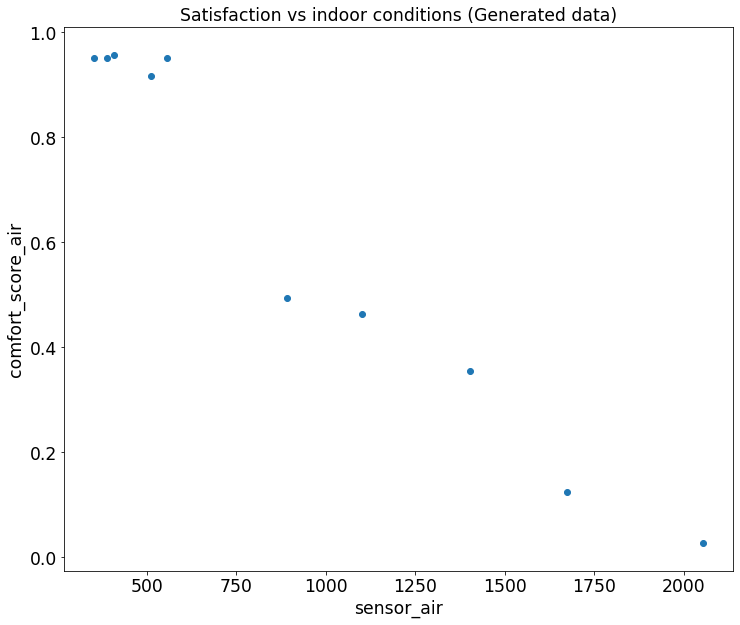

comfort_score_air    0.045569
dtype: float32

In [46]:
sample_size = 10
signal_to_noise_ratio = 5

satisfaction_vs_sensors, satisfaction_vs_sensors_null = generate_dataset_with_sensor_readings_and_satisfaction_scores(sample_size, signal_to_noise_ratio, 'db8')

measurement_name = 'air'
score_name = f'comfort_score_{measurement_name}'
sensor_name = f'sensor_{measurement_name}'

sensor_values = satisfaction_vs_sensors[[sensor_name]]
score_values = satisfaction_vs_sensors[[score_name]]

sensor_values_null = satisfaction_vs_sensors_null[[sensor_name]]
score_values_null = satisfaction_vs_sensors_null[[score_name]]

# Plot the original data
X_sorted, y_sorted = sort_for_plotting(sensor_values, score_values)

plt.figure(figsize=(12, 10))
plt.scatter(X_sorted, y_sorted)
plt.xlabel(f"{sensor_name}")
plt.ylabel(f"{score_name}")
plt.title(f'Satisfaction vs indoor conditions (Generated data)')
plt.show()

effect_size(score_values, score_values_null)

In [47]:
sensor_values

,sensor_air
0,1101.870850
1,890.421387
2,2053.844971
3,555.908264
4,511.954895
5,353.045837
6,1402.470703
7,407.496582
8,1672.494995
9,389.487152


## Hypothesis Testing

**Type I error** is rejection of the Null Hypothesis when it's true

**Type II error** is not rejecting a Null Hypothesis when it's false - a false positive

**Test power** is the probability of rejecting the Null Hypothesis when it's false. Therefore, power is a probability of avoiding a Type II error.

In this power analysis hypotheiss will be tested using a T-Test.

### T-test for the means of two independent samples of scores.

H0: $\mu_1 = \mu_2$

H1: $\mu_1 \neq \mu_2$

where,  $\mu_1,  \mu_2$ are the sample means.


While running the test multiple times 


Confidence level $\alpha$, sample size $N$ needs to be determined in order to 


In [48]:
def test_hypothesis(sample_size, confidence_level, noise_standard_deviation, measurement_name):

    satisfaction_vs_sensors, satisfaction_vs_sensors_null = generate_dataset_with_sensor_readings_and_satisfaction_scores(sample_size, noise_standard_deviation, 'db8')

    score_name = f'comfort_score_{measurement_name}'

    score_values = satisfaction_vs_sensors[[score_name]]
    score_values_null = satisfaction_vs_sensors_null[[score_name]]

    t_statistics, p_value_t = ttest_ind(score_values, score_values_null)

    result = p_value_t < confidence_level
    
    return result

### Example

In [49]:
confidence_level = 0.05 

test_hypothesis(sample_size, confidence_level, signal_to_noise_ratio, measurement_name)

array([False])

For the set parameters the test didn't reject the null hypotheis. We could say that both samples are similar although we know they are not supposed to be. 

Error type II was commited due to the small power of the test. In order to increase the power, the sample size needs to be increased too (or the confidence level). 

### Significance of the relationship - Regression

Summary statistics for the OLS displayes the R-squared that shows how well the data fits the model.

F-statistic that measures the significance of the fit and T-statistics measures the significance of the estimated coefficients.

F-statistic:

    H0: All of the regression coefficients are equal to zero

    H1: Model has good predictive capability

T-statistics:

    H0: Variable is not significant to the model

    H1: Significant relationship between the response and explanatory variables


In terms of the model residual distribution, Jarque-Bera Test for the normality.


**Statistical model for Linear Regression Problem:***

$y = \beta_0 + \beta_1 \cdot x + \epsilon$

where,

$\epsilon \sim Normal(0, \sigma^2)$ and $\beta_1$ is the slope.

Null model: $\beta_1 = 0$

Alternative model: $\beta_1 \ne 0$

**Statistical model for Polynomial Regression Problem:***

$y = \beta_0 + \sum^p_i \beta_i \cdot x + \epsilon$

where, 

$\epsilon \sim Normal(0, \sigma^2)$

and $p$ is the number of predictors.

Null model: $\beta_1 = · · · = \beta_p = 0$ 

Alternative model:$\exists \beta_i \neq 0$


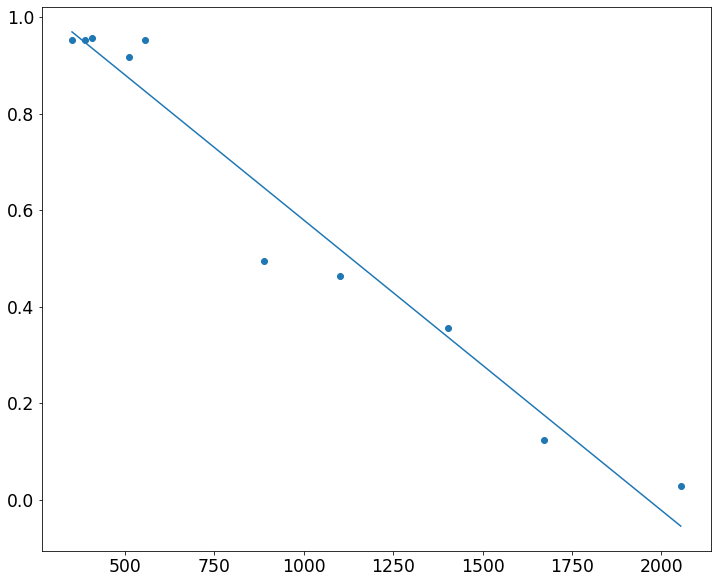

C:\Users\mam\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      comfort_score_air   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     192.7
Date:                Fri, 08 Nov 2019   Prob (F-statistic):           7.02e-07
Time:                        16:46:39   Log-Likelihood:                 12.360
No. Observations:                  10   AIC:                            -20.72
Df Residuals:                       8   BIC:                            -20.12
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1820      0.048     24.864      0.000       1.072       1.292
x1            -0.0006   4.34e-05    -13.880      0.000      -0.001      -0.001
==============================================================================
Omnibus:                        1.713   Durbin-Watson:                   1.657
Prob(Omnibus):                  0.425   Jarque-Bera (JB):                0.559
Skew:                          -0.578   Prob(JB):                        0.756
Kurtosis:                       2.952   Cond. No.                     2.10e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [50]:
degree = 1
# sensor_values_centered = sensor_values - np.mean(sensor_values)

# scaler = MinMaxScaler()
# sensor_values_scaled = sensor_values

# Perform polynomial transformation
polynomial_features = PolynomialFeatures(degree=degree)
sensor_values_polynomial = polynomial_features.fit_transform(sensor_values)

# Fit the model
model = sm.OLS(score_values, sensor_values_polynomial).fit()
score_values_predicted = model.predict(sensor_values_polynomial)

# sensor_values = scaler.inverse_transform(sensor_values_scaled)
# Plot the prediction
plt.scatter(sensor_values, score_values)
sensor_values_sorted, score_values_predicted_sorted = sort_for_plotting(sensor_values, score_values_predicted)
plt.plot(sensor_values_sorted, score_values_predicted_sorted)
plt.show()

# Show summary statistics
model.summary()

In [18]:
model.params

const    0.393124
x1      -0.397639
dtype: float64

In [19]:
model.pvalues[1] < 0.01

False

The p_value of the test is larger then the confidence level which means there is no evidence of a significant relationship between the variables. 

In [20]:
slope_coeff = model.params[1]
standard_error = model.bse[1]

test_statistics = slope_coeff / standard_error
test_statistics

-2.5258365110462195

In [21]:
critical_value = stats.t.sf(np.abs(test_statistics), sample_size - degree - 1) * 2

critical_value

0.03548475751224951

In [39]:
model.rsquared_adj

0.44366597785382833

In [23]:
effect_size = model.rsquared
F = model.rsquared / ((1 - model.rsquared) / (sample_size - degree - 1))
stats.f.sf(F, degree, sample_size - degree - 1)

0.03548475423177876

In [24]:
model.rsquared

0.44366597785382833

## Power Simulation

To find the right amount of data needed, a Power Simulation will be run to test over different confidence levels, $\alpha$ and sample sizes $N$. 

Simulation executes a function that performs the T-Test a number of times, defined by a variable *number_of_experiments* and calculates a mean of null hypothesis rejections saving the sample size and confidence level in a list. After performing all calculations a table with the results is returned.

### T-test for means

In [215]:
sample_size = [30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 250]
# sample_size = [200, 500, 1000]

alpha_levels = [0.1, 0.05, 0.01]
number_of_experiments = 100

def power_simulation_testing(number_of_experiments, sample_size, alpha_levels, noise_standard_deviation, measurement_name):
    rejections = np.zeros(number_of_experiments, dtype=bool)
    test_power = []
    for size in tqdm_notebook(sample_size):
        for alpha in tqdm_notebook(alpha_levels):
            for experiment in tnrange(number_of_experiments):

                rejections[experiment] = test_hypothesis(size, alpha, noise_standard_deviation, measurement_name)

            test_power.append([size, np.mean(rejections), alpha])
        
    return test_power


In [216]:
test_power_air = power_simulation_testing(number_of_experiments, sample_size, alpha_levels, noise_standard_deviation, 'air')

test_power_temperature = power_simulation_testing(number_of_experiments, sample_size, alpha_levels, noise_standard_deviation, 'heat_index')

test_power_noise = power_simulation_testing(number_of_experiments, sample_size, alpha_levels, noise_standard_deviation, 'noise')

test_power_light = power_simulation_testing(number_of_experiments, sample_size, alpha_levels, noise_standard_deviation, 'light')

KeyboardInterrupt: 

In [217]:
test_power_table_air = pd.DataFrame(test_power_air, columns=['Sample Size', 'Power', 'Alpha'])
test_power_table_temperature = pd.DataFrame(test_power_temperature, columns=['Sample Size', 'Power', 'Alpha'])
test_power_table_noise = pd.DataFrame(test_power_noise, columns=['Sample Size', 'Power', 'Alpha'])
test_power_table_light = pd.DataFrame(test_power_light, columns=['Sample Size', 'Power', 'Alpha'])

scores = [test_power_table_air, test_power_table_temperature, test_power_table_noise, test_power_table_light]
names = ['Air', 'Temperature', 'Noise', 'Light']

i = 1

# Plot test power
plt.figure(figsize=(20, 18))
for plot in scores:

    plt.subplot(2, 2, i)

    for alpha in alpha_levels:
        plt.plot(plot.loc[plot['Alpha'] == alpha, 'Sample Size'],
                 plot.loc[plot['Alpha'] == alpha, 'Power'], 'o-',
                 label = f"Confidence level: {alpha}")

    plt.xlabel(f'Number of samples for {names[i - 1]}')
    plt.ylabel('Power')
    plt.axhline(y = 0.8, color='r')
    plt.title('Test Power vs Sample Size')
    plt.legend()

    i = i + 1

NameError: name 'test_power_temperature' is not defined

### Slope test for regression

In [30]:
def test_hypothesis_regression(sample_size, confidence_level, signal_to_noise_ratio, measurement_name):

    satisfaction_vs_sensors, satisfaction_vs_sensors_null = generate_dataset_with_sensor_readings_and_satisfaction_scores(sample_size, signal_to_noise_ratio, 'db8')

    score_name = f'comfort_score_{measurement_name}'
    sensor_name = f'sensor_{measurement_name}'

    sensor_values = satisfaction_vs_sensors[[sensor_name]]
    score_values = satisfaction_vs_sensors[[score_name]]
    
    sensor_values = sensor_values - np.mean(sensor_values)
    sensor_values = MinMaxScaler().fit_transform(sensor_values)

    degree = 1

    # Perform polynomial transformation
    polynomial_features = PolynomialFeatures(degree=degree)
    sensor_values_polynomial = polynomial_features.fit_transform(sensor_values)

    # Fit the model
    model = sm.OLS(score_values, sensor_values_polynomial).fit()
    score_values_predicted = model.predict(sensor_values_polynomial)
    
    result = model.pvalues[1] < 0.05
    
    return result

In [31]:
def power_simulation_testing_regression(number_of_experiments, sample_size, alpha_levels, signal_to_noise_ratio_table, measurement_name):
    rejections = np.zeros(number_of_experiments, dtype=bool)
    test_power = []
    for size in tqdm_notebook(sample_size):
        for noise in tqdm_notebook(signal_to_noise_ratio_table):
            for experiment in tnrange(number_of_experiments):
                
                rejections[experiment] = test_hypothesis_regression(size, alpha_levels, noise, measurement_name)
                
            test_power.append([size, np.mean(rejections), noise])
        
    return test_power

In [51]:
sample_size = [5, 10, 15, 20, 25, 35, 45, 60, 75, 100, 120]
# sample_size = [200, 500, 1000]

alpha_levels = [0.01]
number_of_experiments = 100

signal_to_noise_ratio_table = [0.5, 0.75, 1, 2]

test_power_air = power_simulation_testing_regression(number_of_experiments, sample_size, alpha_levels, signal_to_noise_ratio_table, 'air')

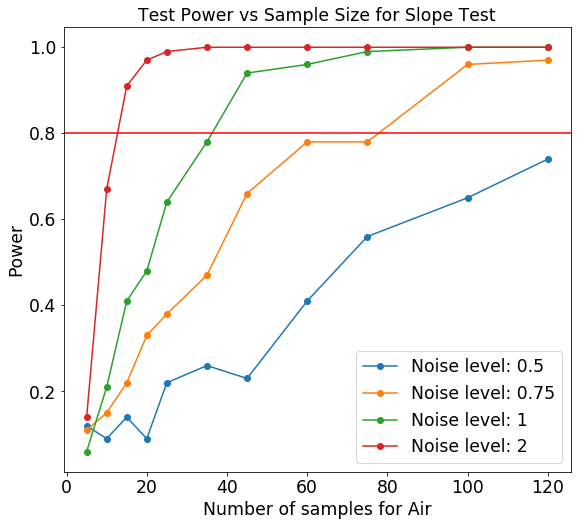

In [52]:
test_power_table_air = pd.DataFrame(test_power_air, columns=['Sample Size', 'Power', 'Noise'])

scores = [test_power_table_air]
names = ['Air']

i = 1

# Plot test power
plt.figure(figsize=(20, 18))
for plot in scores:

    plt.subplot(2, 2, i)

    for noise in signal_to_noise_ratio_table:
        plt.plot(plot.loc[plot['Noise'] == noise, 'Sample Size'],
                 plot.loc[plot['Noise'] == noise, 'Power'], 'o-',
                 label = f"Noise level: {noise}")

    plt.xlabel(f'Number of samples for {names[i - 1]}')
    plt.ylabel('Power')
    plt.axhline(y = 0.8, color='r')
    plt.title('Test Power vs Sample Size for Slope Test')
    plt.legend()

    i = i + 1

In [36]:
test_power_table_air[test_power_table_air['Power'] > 0.8]

,Sample Size,Power,Noise
27,45,0.87,1.00
31,60,0.97,1.00
34,75,0.87,0.75
35,75,0.98,1.00
38,100,0.96,0.75
39,100,1.00,1.00
42,120,0.99,0.75
43,120,1.00,1.00


Having a sample of size 10 will result in the power of 80%